# Стартап, который продаёт продукты питания 

**Цель исследования:**
Анализ поведения пользователей мобильного приложения и анализ результатов A/A/B-эксперимента

**Описание данных:**
Каждая запись в логе — это действие пользователя, или событие. 
* EventName — название события;
* DeviceIDHash — уникальный идентификатор пользователя;
* EventTimestamp — время события;
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**План работы:**
Шаг 1. Открыть файл с данными и изучить общую информацию.

Шаг 2. Подготовка данных
* Заменить названия столбцов;
* Проверить пропуски и типы данных;
* Добавить столбец даты и времени, а также отдельный столбец дат;

Шаг 3. Изучим и проверим данные
* Сколько всего событий в логе?
* Сколько всего пользователей в логе?
* Сколько в среднем событий приходится на пользователя?
* Данными за какой период мы располагаем? Изучим, как меняется количество данных.
* Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

Шаг 4. Изучим воронку событий
* Посмотрим, какие события есть в логах, как часто они встречаются.
* Посмотрим, сколько пользователей совершали каждое из этих событий. 
* Предположим, в каком порядке происходят события. 
* По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 
* На каком шаге теряем больше всего пользователей?
* Какая доля пользователей доходит от первого события до оплаты?

Шаг 5. Изучим результаты эксперимента
* Сколько пользователей в каждой экспериментальной группе?
* Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
* Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
* Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
* Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали.

## шаг

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import math as mth
import scipy.stats as sps
import plotly.express as px

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**Промежуточный вывод:**
Мы загрузили необходимые библиотеки и ознакомились с данными

## шаг

Переименую столбцы на более удобные, выполню проверку на дубликаты и избавлюсь от них.

In [3]:
data.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'device_id', 'EventTimestamp': 'event_time', 'ExpId':'exp_id'}, inplace=True)

In [4]:
data.duplicated().sum() 

413

In [5]:
data  = data.drop_duplicates()

Теперь проверим соответствуют ли типы данных записанной информации.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  243713 non-null  object
 1   device_id   243713 non-null  int64 
 2   event_time  243713 non-null  int64 
 3   exp_id      243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


In [7]:
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')
data

,event_name,device_id,event_time,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247
244122,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246


In [8]:
data['date'] = pd.to_datetime(data['event_time']).dt.date
data['date'] = pd.to_datetime(data['date'])

In [9]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
event_name,0.000000
device_id,0.000000
event_time,0.000000
exp_id,0.000000
date,0.000000


**Промежуточный вывод:** предобработка данных была выполнена, мы переименовали столбцы, избавились от дубликатов, а также откорректировали типы данных. Пропусков нет.

## шаг

Изучим и проверим данные. Сколько всего событий в логе?

In [10]:
events = len(data)
print('всего событий в логе:', events)

всего событий в логе: 243713


Сколько всего пользователей в логе?

In [11]:
users = len(data['device_id'].unique())
print('всего пользователей в логе:', users)

всего пользователей в логе: 7551


Сколько в среднем событий приходится на пользователя?

In [12]:
avg_events = round(events / users, 2)
print('в среднем на пользователя приходится:', avg_events, 'событий')

в среднем на пользователя приходится: 32.28 событий


Данными за какой период мы располагаем? Найдём максимальную и минимальную дату. Изучим, как меняется количество данных: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Определим, с какого момента данные полные и отбросим более старые.

In [13]:
max_date = data['date'].max()
max_date

Timestamp('2019-08-07 00:00:00')

In [14]:
min_date = data['date'].min()
min_date

Timestamp('2019-07-25 00:00:00')

У нас есть данные с 25.07.2019 по 08.07.2019

In [15]:
group_246 = data.query('exp_id == 246')
group_247 = data.query('exp_id == 247')
group_248 = data.query('exp_id == 248')

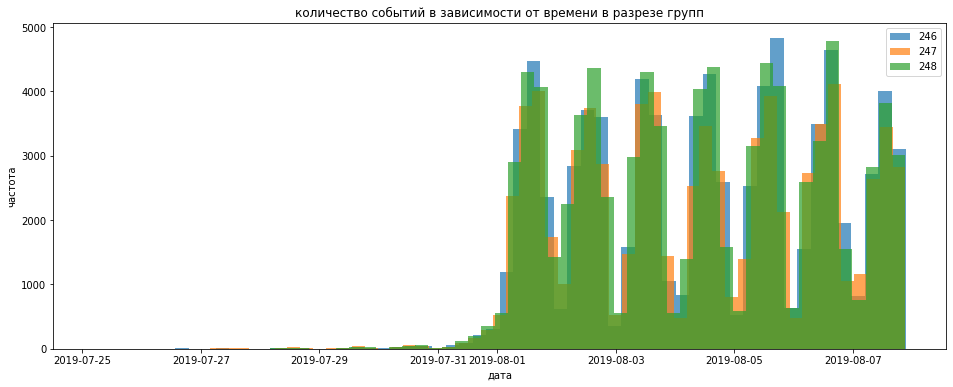

In [16]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.hist(group_246['event_time'], bins = 60, alpha=0.7, label='246')
plt.hist(group_247['event_time'], bins = 60, alpha=0.7, label='247')
plt.hist(group_248['event_time'], bins = 60, alpha=0.7, label='248')
plt.title('количество событий в зависимости от времени в разрезе групп')
plt.xlabel('дата')
plt.ylabel('частота')
plt.legend()
plt.show()

Судя по графику, у нас по всем трём группам  полные данные только с 1 по 8 августа. Отбросим строки с более ранними датами.

In [17]:
date_threshold = pd.to_datetime('2019-08-01', format = '%Y-%m-%d')
data = data[data['date'] >= date_threshold]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  240887 non-null  object        
 1   device_id   240887 non-null  int64         
 2   event_time  240887 non-null  datetime64[ns]
 3   exp_id      240887 non-null  int64         
 4   date        240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.0+ MB


In [18]:
events_2 = len(data)
events_diff_abs = events - events_2
events_diff_rel = round((events_2 / events -1) * 100 , 2)
print('Количество событий до фильтрации:', events)
print('Количество событий после фильтрации:', events_2)
print('Абсолютная разница', events_diff_abs)
print('Относительная разница', events_diff_rel)
print()

users_2 = len(data['device_id'].unique())
users_diff_abs = users - users_2
users_diff_rel = round((users_2 / users -1) * 100 , 2)
print('Количество пользователей до фильтрации:', users)
print('Количество пользователей после фильтрации:', users_2)
print('Абсолютная разница', users_diff_abs)
print('Относительная разница', users_diff_rel)
print()

Количество событий до фильтрации: 243713
Количество событий после фильтрации: 240887
Абсолютная разница 2826
Относительная разница -1.16

Количество пользователей до фильтрации: 7551
Количество пользователей после фильтрации: 7534
Абсолютная разница 17
Относительная разница -0.23



Количество событий до фильтрации - 243713, после - 240887, отбросили 2 826 записей. Количество пользователей до фильтрации - 7551, после - 7534. Разность - 17

Проверим, что у нас есть пользователи из всех трёх экспериментальных групп.

In [19]:
data.groupby('exp_id')['device_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: device_id, dtype: int64

**Промежуточный вывод:** Нам пришлось отбросить данные за половину периода, так как они были распределены неравномерно и почти  весь объём данных приходится на период с 1 по 8 августа. Количество событий до фильтрации - 243713, после - 240887, отбросили 2 826 записей. Количество пользователей до фильтрации - 7551, после - 7534. Разность - 17.

## шаг

Изучим воронку событий.
Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем по частоте.
Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [20]:
def event_count(event):
    users_count = data[data['event_name'] == event]['device_id'].nunique()
    return users_count

In [21]:
n_events = data['event_name'].value_counts().reset_index()
n_events.columns = ['event_name', 'events']
n_events = n_events.query('event_name != "Tutorial"')
n_events['users'] = n_events['event_name'].apply(event_count)
n_events = n_events.sort_values(by='users', ascending=False)
n_events['percent'] = n_events['users'] / 7419 * 100

n_events

,event_name,events,users,percent
0,MainScreenAppear,117328,7419,100.000000
1,OffersScreenAppear,46333,4593,61.908613
2,CartScreenAppear,42303,3734,50.330233
3,PaymentScreenSuccessful,33918,3539,47.701847


Предположим, в каком порядке происходят события. 
Сначала пользователь заходит на главный экран(MainScreenAppear), потом он видит экран с предложением пройти обучение(MainScreenAppear). Всего 11% пользователей его проходят. Затем видит предложения по товарам(OffersScreenAppear). Потом отображается корзина(CartScreenAppear), а после уведомление об успешной оплате(PaymentScreenSuccessful).

По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

In [22]:
n_events['conversion'] = 0
for i in range(0, len(n_events['percent'])):
    if i == 0:
        n_events.loc[i, 'conversion'] = 100
    else:
        n_events.loc[i, 'conversion'] = round(int(n_events['users'].iloc[i]) / int(n_events['users'].iloc[i-1]), 2) * 100

display(n_events)

,event_name,events,users,percent,conversion
0,MainScreenAppear,117328,7419,100.000000,100
1,OffersScreenAppear,46333,4593,61.908613,62
2,CartScreenAppear,42303,3734,50.330233,81
3,PaymentScreenSuccessful,33918,3539,47.701847,95


Больше всего пользователей теряется при переходе с главного экрана на страницу с предложениями.

Ответим на вопрос: какая доля пользователей доходит от первого события до оплаты?

In [23]:
print('От первого события до оплаты доходит' , round((n_events['users'].iloc[3]/n_events['users'].iloc[0]) * 100, 2) ,'% пользователей')

От первого события до оплаты доходит 47.7 % пользователей


In [36]:
fig = px.funnel(data, x=n_events['percent'], y=n_events['event_name'])
textposition = "inside",
textinfo = "value+percent initial"
fig.update_layout(title='Воронка', title_x = 0.5);
fig.show()

**Промежуточный вывод:** От первого события до оплаты доходит 47.7 % пользователей. 

Сначала пользователь заходит на главный экран(MainScreenAppear), потом он видит экран с предложением пройти обучение(MainScreenAppear). Всего 11% пользователей его проходят. Затем видит предложения по товарам(OffersScreenAppear). Потом отображается корзина(CartScreenAppear), а после уведомление об успешной оплате(PaymentScreenSuccessful). Больше всего пользователей теряется при переходе с главного экрана на страницу с предложениями (38%). Припереходе вв корзину теряется только 19% пользователей и припереходе к оплате 5%.

## шаг

Изучим результаты эксперимента

Определим сколько пользователей в каждой экспериментальной группе?

In [25]:
exp_users = data.groupby('exp_id')['device_id'].nunique().reset_index()
exp_users.columns = ['exp_id', 'num_users']
exp_users

,exp_id,num_users
0,246,2484
1,247,2513
2,248,2537


In [26]:
exp_users['num_users'].sum()

7534

In [37]:
data.groupby('device_id').agg({'exp_id':'nunique'}).query('exp_id > 1') 


,exp_id
device_id,


Группы соразмерные. Если какой-то пользователь встречается в нескольких группах, то общее количество уникальных пользователей во всех группах будет меньше, чем сумма по каждой группе. Количество пользователей после фильтрации = 7534, также, как и в сумме по группам. Значит каждый пользователь принадлежит только одной группе.

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247. Будем использовать z test, так как он лучше подходит для проверок конверсий. Далее будут упоминаться доли в значении конверсий.

Нулевая гипотеза: нет оснований считать доли разными.

Альтернативная гипотеза: между долями есть значительная разница.

In [28]:
import scipy.stats as stats
import math

def ABtest_Z(df_test, df_control, alpha=0.05):
    
    # Количество событий в тестовой группе
    trial_t = df_test['event_name'].count()
    
    # Количество событий в контрольной группе
    trial_c = df_control['event_name'].count()
    
    # Количество уникальных пользователей в тестовой группе
    users_t = df_test['device_id'].nunique()
    
    # Количество уникальных пользователей в контрольной группе
    users_c = df_control['device_id'].nunique()
   
    # Конверсия в тестовой группе
    p1 = users_t / trial_t

    # Конверсия в контрольной группе
    p2 = users_c / trial_c

    # Конверсия в комбинированном датасете
    p_combined = (users_t + users_c) / (trial_c + trial_t)

    # Разница конверсий в датасетах
    difference = p1 - p2 

    # Стандартная ошибка разницы конверсий
    se = math.sqrt(p_combined * (1 - p_combined) * (1/users_c + 1/users_t))
    
    # Z-статистика
    z_value = difference / se
    
    # P-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z_value)))

    print('p-значение:', p_value)
    print('Конверсия в контроле:', p2)
    print('Конверсия в тесте:', p1)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

ABtest_Z(group_246, group_247)


p-значение: 0.794966374008732
Конверсия в контроле: 0.03232841565105837
Конверсия в тесте: 0.0310422668712039
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Можем считать контрольные группы равными.

Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие (то есть конверсию). Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий.

Нулевая гипотеза: нет оснований считать доли разными.

Альтернативная гипотеза: между долями есть значительная разница.

In [29]:
def ABtest_event(data,group_1, group_2, event, alpha=0.05):
    users_1 = group_1[group_1['event_name'] == event]['device_id'].nunique()
    users_2 = group_2[group_2['event_name'] == event]['device_id'].nunique()

    conversion_1 = users_1 / group_1['device_id'].nunique()
    conversion_2 = users_2 / group_2['device_id'].nunique()

    ABtest_Z(group_1, group_2, alpha)

ABtest_event(data,group_246, group_247, 'MainScreenAppear')
print()
ABtest_event(data, group_246, group_247, 'OffersScreenAppear')
print()
ABtest_event(data, group_246, group_247, 'CartScreenAppear')
print()
ABtest_event(data, group_246, group_247, 'PaymentScreenSuccessful')

p-значение: 0.794966374008732
Конверсия в контроле: 0.03232841565105837
Конверсия в тесте: 0.0310422668712039
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение: 0.794966374008732
Конверсия в контроле: 0.03232841565105837
Конверсия в тесте: 0.0310422668712039
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение: 0.794966374008732
Конверсия в контроле: 0.03232841565105837
Конверсия в тесте: 0.0310422668712039
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение: 0.794966374008732
Конверсия в контроле: 0.03232841565105837
Конверсия в тесте: 0.0310422668712039
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


В каждом из событий статистически значимых отличий между контрольными группами (246 и 247) обнаружено не было.

Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию, а потом с объединённой контрольной группой.

Нулевая гипотеза: нет оснований считать доли разными.

Альтернативная гипотеза: между долями есть значительная разница.

In [30]:
ABtest_Z(group_248, group_246)

p-значение: 0.7818147041870835
Конверсия в контроле: 0.0310422668712039
Конверсия в тесте: 0.029702507536631534
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [31]:
ABtest_Z(group_248, group_247)

p-значение: 0.5896419782111018
Конверсия в контроле: 0.03232841565105837
Конверсия в тесте: 0.029702507536631534
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [32]:
ABtest_event(data,group_246, group_248, 'MainScreenAppear')
print()
ABtest_event(data, group_246, group_248, 'OffersScreenAppear')
print()
ABtest_event(data, group_246, group_248, 'CartScreenAppear')
print()
ABtest_event(data, group_246, group_248, 'PaymentScreenSuccessful')

p-значение: 0.7818147041870835
Конверсия в контроле: 0.029702507536631534
Конверсия в тесте: 0.0310422668712039
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение: 0.7818147041870835
Конверсия в контроле: 0.029702507536631534
Конверсия в тесте: 0.0310422668712039
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение: 0.7818147041870835
Конверсия в контроле: 0.029702507536631534
Конверсия в тесте: 0.0310422668712039
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение: 0.7818147041870835
Конверсия в контроле: 0.029702507536631534
Конверсия в тесте: 0.0310422668712039
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [33]:
ABtest_event(data,group_247, group_248, 'MainScreenAppear')
print()
ABtest_event(data, group_247, group_248,  'OffersScreenAppear')
print()
ABtest_event(data, group_247, group_248,  'CartScreenAppear')
print()
ABtest_event(data, group_247, group_248,  'PaymentScreenSuccessful')

p-значение: 0.5896419782111018
Конверсия в контроле: 0.029702507536631534
Конверсия в тесте: 0.03232841565105837
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение: 0.5896419782111018
Конверсия в контроле: 0.029702507536631534
Конверсия в тесте: 0.03232841565105837
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение: 0.5896419782111018
Конверсия в контроле: 0.029702507536631534
Конверсия в тесте: 0.03232841565105837
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение: 0.5896419782111018
Конверсия в контроле: 0.029702507536631534
Конверсия в тесте: 0.03232841565105837
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [34]:
 # Проведем статистический тест для группы с измененным шрифтом и объединенной контрольной группы
ABtest_Z(group_248, data[(data['exp_id'] == 246) | (data['exp_id'] == 247)])

p-значение: 0.5929161168500112
Конверсия в контроле: 0.0319656610629206
Конверсия в тесте: 0.029702507536631534
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [35]:
ABtest_event(data,data[(data['exp_id'] == 246) | (data['exp_id'] == 247)], group_248, 'MainScreenAppear')
print()
ABtest_event(data, data[(data['exp_id'] == 246) | (data['exp_id'] == 247)], group_248,  'OffersScreenAppear')
print()
ABtest_event(data, data[(data['exp_id'] == 246) | (data['exp_id'] == 247)], group_248,  'CartScreenAppear')
print()
ABtest_event(data, data[(data['exp_id'] == 246) | (data['exp_id'] == 247)], group_248,  'PaymentScreenSuccessful')

p-значение: 0.5929161168500112
Конверсия в контроле: 0.029702507536631534
Конверсия в тесте: 0.0319656610629206
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение: 0.5929161168500112
Конверсия в контроле: 0.029702507536631534
Конверсия в тесте: 0.0319656610629206
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение: 0.5929161168500112
Конверсия в контроле: 0.029702507536631534
Конверсия в тесте: 0.0319656610629206
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

p-значение: 0.5929161168500112
Конверсия в контроле: 0.029702507536631534
Конверсия в тесте: 0.0319656610629206
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Так как нами не была отвергнута ни одна нулевая гипотеза ни на одном этапе, можно утверждать, что изменение шрифта не несёт значимых изменений в конверсии.

Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

Я использовала уровень значимости 0.05. Всего у нас было три группы, которые мы сравнивали между собой по одному параметру(конверсии), также общая контрольная группа, сравнение было по четырём типам событий. Следовательно было 16 сравнений. Это довольно-таки много и сиьно повышает риск ошибки первого рода, когда ошибочно отвергается нулевая гипотеза. Для корректировки я бы использовала самую простую корректировку методом Бонферрони. Тогда значимость была бы 0.3%. Но я не вижу смысла пересчитывать, так как мы не отклонили ни одну нулевую гипотезу.


**Вывод:**

Мы проанализировали основной массив данных ААВ теста на период с 1 по 8 августа. 

Проанализировав воронку продаж пришли к следующим выводам: от первого события до оплаты доходит 47.7 % пользователей.

Сначала пользователь заходит на главный экран(MainScreenAppear), потом он видит экран с предложением пройти обучение(MainScreenAppear). Всего 11% пользователей его проходят. Затем видит предложения по товарам(OffersScreenAppear). Потом отображается корзина(CartScreenAppear), а после уведомление об успешной оплате(PaymentScreenSuccessful). Больше всего пользователей теряется при переходе с главного экрана на страницу с предложениями (38%). Припереходе вв корзину теряется только 19% пользователей и припереходе к оплате 5%.

Затем мы сравнили конверсии по всем отдельным событиям между двумя контрольными и одной тестовой группой. Значительных отличий обнаружено не было. Можем утверждать, что изменение шрифта на тестируемый не влияет на конверсию.